In [1]:
import os
import fnmatch
import pandas as pd
from os.path import isfile, join
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Vertex Count

    In this script I will analyze the vertex count in a Cairo Lattice if we increse linearly up from 0 mT to 50 mT with a rate of 0.016 mT/s (3000 s). Then, we are analyzing the output data of Script-1.2.
    
    In this scripts there are 2 independent branches, run until 2 or run until 1 and then from 2

In [2]:
data_directory = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-1.3"

In [3]:
slope = 50/3000
slope

0.016666666666666666

In [ ]:
Cairo = []
for file in os.listdir(data_directory):
    if fnmatch.fnmatch(file, 'ACI_CairoLattice_50mT-3000s_l10_exp*.dat'):
        print(file)
        Cairo.append(pd.read_csv(join(data_directory,file), sep = "\t", index_col = [0,1])) 
        
keys_Cairo = []
for i in range(len(Cairo)):
    keys_Cairo.append(i)

In [5]:
Cairo_exp = pd.concat(Cairo, keys = keys_Cairo)

In [6]:
Cairo_exp.index.names = ['Exp', 'frame', 'id']

In [7]:
Cairo_exp["type"] = np.NaN

# 4-fold vertices classification

Cairo_exp.loc[Cairo_exp.charge==-4, "type"] = "Q = -4"
Cairo_exp.loc[Cairo_exp.charge==-2, "type"] = "Q = -2"
Cairo_exp.loc[Cairo_exp.charge==+2, "type"] = "Q = +2"
Cairo_exp.loc[Cairo_exp.charge==+4, "type"] = "Q = +4"

zeroq = Cairo_exp.charge==0

dipole_magnitude = np.sqrt(Cairo_exp[zeroq].dx**2+Cairo_exp[zeroq].dy**2)

Cairo_exp.loc[zeroq & (dipole_magnitude<1), "type"] = "Q = 0"
Cairo_exp.loc[zeroq & (dipole_magnitude>2) , "type"] = "Q = 0"

# 3-fold vertices classification

Cairo_exp.loc[Cairo_exp.charge==+1, "type"] = "Q = +1"
Cairo_exp.loc[Cairo_exp.charge==-1, "type"] = "Q = -1"
Cairo_exp.loc[Cairo_exp.charge==+3, "type"] = "Q = +3"
Cairo_exp.loc[Cairo_exp.charge==-3, "type"] = "Q = -3"

In [8]:
Cairo_exp['field'] = (Cairo_exp.index.get_level_values('frame'))/100*slope

In [9]:
def count_types(data):
    
    data["mean"] = 0
    cats = ["Q = -4", "Q = -2", "Q = 0", "Q = +2", "Q = +4","Q = +1","Q = -1","Q = +3","Q = -3" ]
    zeros = pd.DataFrame(np.zeros(len(cats)), columns=["mean"], index = cats)
    zeros.index.name="type"
    counts = zeros+data.groupby("type").count()
    counts[counts.isna()]=0
    return counts

Cairo_exp["mean"]= 0


### Branch 1. Separatieng the vertex count by coordination

In [10]:
count_m = Cairo_exp.loc[:,["type","field","coordination"]].groupby(["Exp","field","coordination"]).apply(count_types)
increase = (count_m/Cairo_exp.groupby(["Exp","field","coordination"]).count()).filter(["mean"])

In [11]:
a = increase.query('mean != 0')

In [12]:
a = a.reset_index()
del a['coordination']
a = a.set_index(['Exp', 'field','type'])
a

mean
Exp field type            
0   0.0   Q = +1  0.410200
          Q = +3  0.115299
          Q = -1  0.343681
          Q = -3  0.130820
          Q = +2  0.280000
...                    ...
39  50.0  Q = -3  0.077605
          Q = +2  0.320000
          Q = +4  0.048889
          Q = -2  0.151111
          Q = 0   0.480000

[107616 rows x 1 columns]

In [13]:
def evenly_spaced(series,space):
    series_w_space = pd.concat([
        series.droplevel([0,2]),series.droplevel([0,2]).reindex(space)]
    ).groupby(series.droplevel([0,2]).index.name).first().sort_index()
    
    series_w_space = series_w_space.interpolate(method="index")
    return series_w_space.loc[space]

In [14]:
field = np.linspace(0,50,75)


vert_prop_evenspace_m = a.groupby(["Exp","type"]).apply(evenly_spaced,field)

In [15]:
v_counts_m = vert_prop_evenspace_m.groupby(["field","type"]).mean()
v_counts_m["err"] = vert_prop_evenspace_m.groupby(
    ["field","type"]).std()/np.sqrt(vert_prop_evenspace_m.groupby(["field","type"]).count().values)

In [16]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "green", "purple", 
                                                    "orange", "royalblue", "limegreen", 
                                                    "blueviolet","darkorange", "tomato",
                                                    "red"]) 

In [17]:
v_counts_m

mean       err
field type                      
0.0   Q = +1  0.373171  0.003616
      Q = +2  0.247667  0.003852
      Q = +3  0.127993  0.002321
      Q = +4  0.060444  0.002540
      Q = -1  0.374224  0.003108
...                ...       ...
50.0  Q = -1  0.520233  0.003646
      Q = -2  0.134889  0.003145
      Q = -3  0.079102  0.001802
      Q = -4  0.009222  0.000719
      Q = 0   0.482667  0.005396

[675 rows x 2 columns]

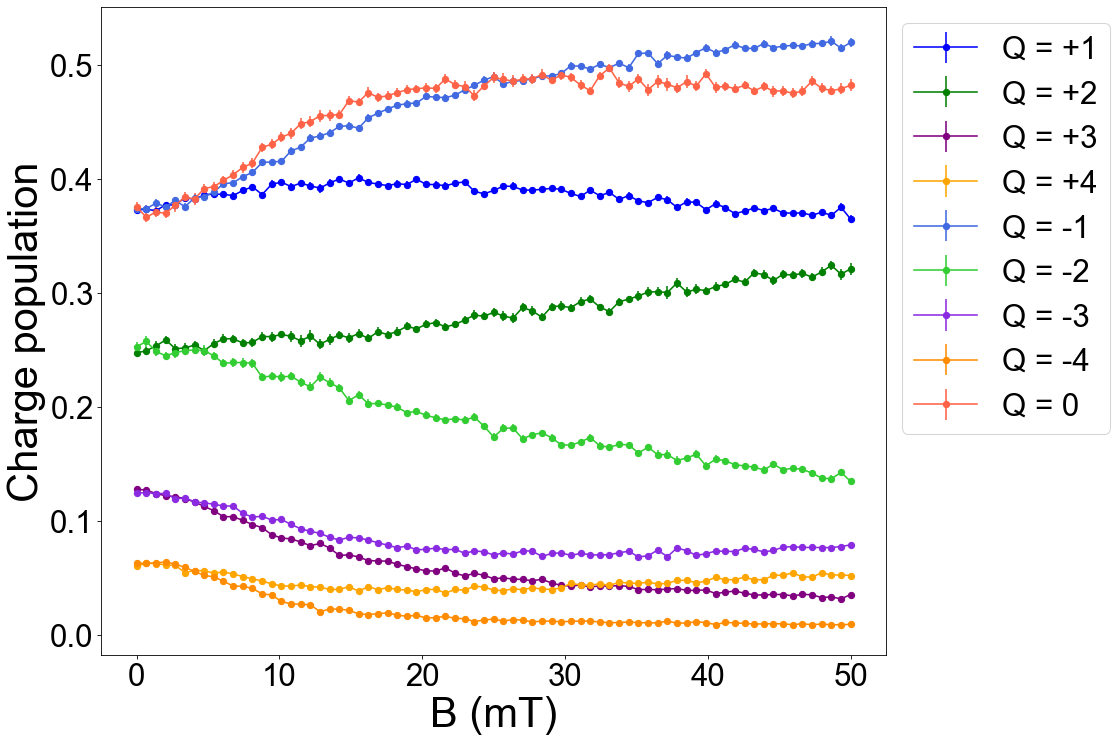

In [18]:
fig, ax1 = plt.subplots(figsize=(15,10))

for typ_m, mtype in v_counts_m.groupby('type'):
    
    plt.errorbar(mtype.index.get_level_values("field"), mtype["mean"],yerr = mtype["err"], fmt ='-o', label = typ_m)

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)  

ax1.legend(fontsize = 30, bbox_to_anchor=(1, 1))
ax1.set_xlabel('B (mT)', size = 40)
ax1.set_ylabel('Charge population', size = 40)

plt.tight_layout()

#### Now I will separate the two coordination lattices

In [19]:
a = increase.query('mean != 0')
a = a.reset_index()
latt3 = a.query('coordination == 3')
latt4 = a.query('coordination == 4')
del latt3['coordination']
del latt4['coordination']
latt3 = latt3.set_index(['Exp', 'field','type'])
latt4 = latt4.set_index(['Exp', 'field','type'])

In [20]:
latt3

mean
Exp field     type            
0   0.000000  Q = +1  0.410200
              Q = +3  0.115299
              Q = -1  0.343681
              Q = -3  0.130820
    0.166667  Q = +1  0.385809
...                        ...
39  49.833333 Q = -3  0.068736
    50.000000 Q = +1  0.368071
              Q = +3  0.031042
              Q = -1  0.523282
              Q = -3  0.077605

[48160 rows x 1 columns]

In [21]:
field = np.linspace(0,50,75)

vert_prop_evenspace_latt3 = latt3.groupby(["Exp","type"]).apply(evenly_spaced,field)
vert_prop_evenspace_latt4 = latt4.groupby(["Exp","type"]).apply(evenly_spaced,field)

In [22]:
v_counts_latt3 = vert_prop_evenspace_latt3.groupby(["field","type"]).mean()
v_counts_latt3["err"] = vert_prop_evenspace_latt3.groupby(
    ["field","type"]).std()/np.sqrt(vert_prop_evenspace_latt3.groupby(["field","type"]).count().values)

v_counts_latt4 = vert_prop_evenspace_latt4.groupby(["field","type"]).mean()
v_counts_latt4["err"] = vert_prop_evenspace_latt4.groupby(
    ["field","type"]).std()/np.sqrt(vert_prop_evenspace_latt4.groupby(["field","type"]).count().values)

In [23]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "navy", "tomato", 
                                                    "red", "plum", "blue", 
                                                    "navy", "tomato",
                                                    "red"]) 

Q = +2
Q = +4
Q = -2
Q = -4
Q = 0
Q = +1
Q = +3
Q = -1
Q = -3


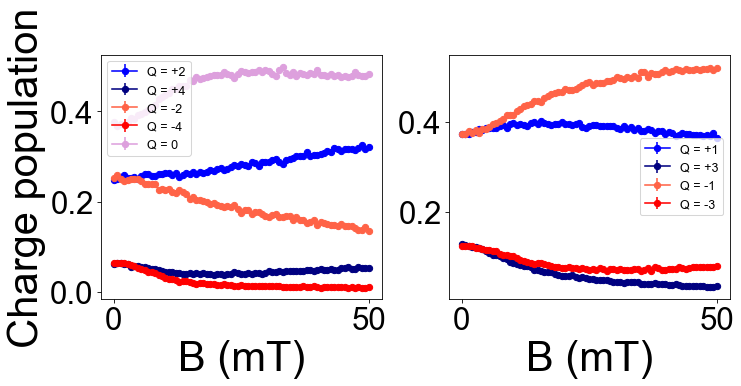

In [24]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))

for typ_m, mtype in v_counts_latt4.groupby('type'):
    print(typ_m)
    
    ax[0].errorbar(mtype.index.get_level_values("field"), mtype["mean"],yerr = mtype["err"],fmt = '-o', label = typ_m)

for typ_m, mtype in v_counts_latt3.groupby('type'):
    print(typ_m)
    ax[1].errorbar(mtype.index.get_level_values("field"), mtype["mean"],yerr = mtype["err"], fmt ='-o',label = typ_m)

ax[0].tick_params(axis='y', labelsize=30)
ax[0].tick_params(axis='x', labelsize=30)  

ax[0].legend(fontsize = 12)
ax[0].set_xlabel('B (mT)', size = 40)
ax[0].set_ylabel('Charge population', size = 40)

ax[1].tick_params(axis='y', labelsize=30)
ax[1].tick_params(axis='x', labelsize=30)  

ax[1].legend(fontsize = 12)
ax[1].set_xlabel('B (mT)', size = 40)


plt.tight_layout()

### Branch 2 . Do the same but without separating the vertices by coordination

In [25]:
count_m = Cairo_exp.loc[:,["type","field"]].groupby(["Exp","field"]).apply(count_types)
increase = (count_m/Cairo_exp.groupby(["Exp","field"]).count()).filter(["mean"])

In [26]:
def evenly_spaced(series,space):
    series_w_space = pd.concat([
        series.droplevel([0,2]),series.droplevel([0,2]).reindex(space)]
    ).groupby(series.droplevel([0,2]).index.name).first().sort_index()
    
    series_w_space = series_w_space.interpolate(method="index")
    return series_w_space.loc[space]

In [27]:
field = np.linspace(0,50,75)


vert_prop_evenspace_m = increase.groupby(["Exp","type"]).apply(evenly_spaced,field)

In [28]:
v_counts_m = vert_prop_evenspace_m.groupby(["field","type"]).mean()
v_counts_m["err"] = vert_prop_evenspace_m.groupby(
    ["field","type"]).std()/np.sqrt(vert_prop_evenspace_m.groupby(["field","type"]).count().values)

In [29]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "green", "purple", 
                                                    "orange", "royalblue", "limegreen", 
                                                    "blueviolet","darkorange", "tomato",
                                                    "red"]) 

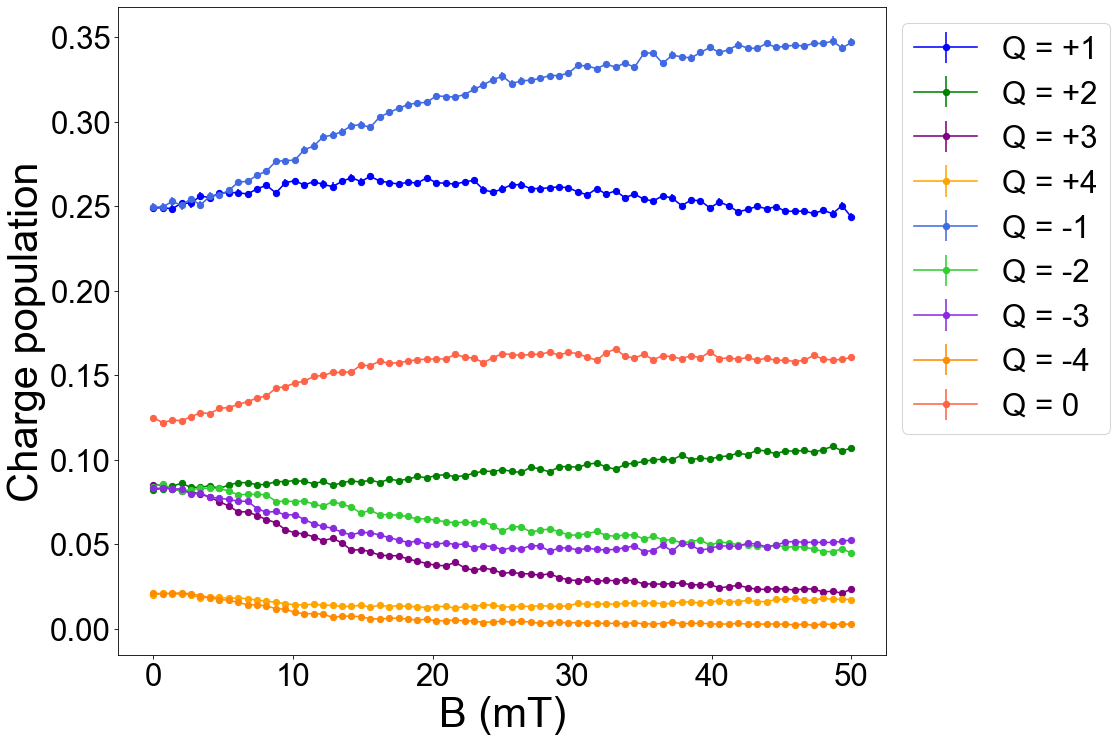

In [30]:
fig, ax1 = plt.subplots(figsize=(15,10))

for typ_m, mtype in v_counts_m .groupby('type'):
    
    plt.errorbar(mtype.index.get_level_values("field"), mtype["mean"],yerr = mtype["err"], fmt ='-o', label = typ_m)

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)  

ax1.legend(fontsize = 30, bbox_to_anchor=(1, 1))
ax1.set_xlabel('B (mT)', size = 40)
ax1.set_ylabel('Charge population', size = 40)

plt.tight_layout()